In [1]:
import sys
sys.path.append('../..')
from model import processing
from model.amm.money_market import MoneyMarket, MoneyMarketAsset, CDP
from model.amm.trade_strategies import liquidate_cdps
mm = processing.get_current_money_market()
original_cdps = mm.cdps
print(mm)

Pool Address: 0x1b02E051683b5cfaC5929C25E84adb26ECf87B38
money_market(    liquidity: {'USDC': 468527588873, 'USDT': 398286270990, 'WBTC': 1194405241, 'DOT': 84292911735736515, 'vDOT': 3098857466618751, 'tBTC': 10188425051753086542, '2-Pool-GDOT': 2222219986467830895949278}
    total borrowed: {'USDC': 611089.2577283779, 'USDT': 758047.2421258215, 'WBTC': 0.3564575603620548, 'DOT': 710437.1625465634, 'vDOT': 23085.212023878496, 'tBTC': 0.0006442537167506749, '2-Pool-GDOT': 0}
    total collateral: {'USDC': 91827.750750062, 'USDT': 63338.47276071308, 'WBTC': 1.3207977614056718, 'DOT': 376465.42663044774, 'vDOT': 236071.81872968937, 'tBTC': 4.580517236011141, '2-Pool-GDOT': 977117.5167608432}



In [2]:
omnipool_router = processing.get_current_omnipool_router()
# print(omnipool_router)
print('Got Omnipool data...')

Got Omnipool data...


In [3]:
from model.amm.omnipool_amm import OmnipoolState
from model.amm.stableswap_amm import StableSwapPoolState

omnipool = omnipool_router.exchanges['omnipool']
omnipool_copy = omnipool.copy()
lrna_price = mm.price('DOT') / omnipool.lrna_price('DOT')
# lrna_price_2 = mm.price('vDOT') / omnipool.lrna_price('vDOT')
# print(lrna_price_1, lrna_price_2)
# lrna_price = (lrna_price_1 + lrna_price_2) / 2

for exchange in [exchange for exchange in omnipool_router.exchanges.values() if isinstance(exchange, StableSwapPoolState)]:
    priced_assets = list(filter(lambda x: x, [tkn[:-2] if tkn[:-2] in mm.prices else (tkn[1:] if tkn[1:] in mm.prices else '') for tkn in exchange.asset_list]))
    print(priced_assets)
    pool_price = sum(mm.price(tkn) for tkn in priced_assets) / len(priced_assets)
    print(f"Average price of assets in {exchange.unique_id} is {pool_price}.")
    # print(exchange, '\n')
    for tkn in exchange.asset_list:
        tkn_name = tkn[:-2] if tkn[-2:].isdigit() else (tkn[1:] if tkn[1:] in mm.prices else tkn)
        print(tkn)
        tkn_price = pool_price
        new_liquidity = exchange.liquidity[tkn]
        if not new_liquidity:
            new_liquidity = exchange.shares / 10 ** 18 * mm.price(tkn_name) / pool_price / len(exchange.asset_list)
        new_lrna = new_liquidity * tkn_price / lrna_price
        new_shares = new_liquidity
        if tkn_name not in omnipool.asset_list:
            omnipool.add_token(
                tkn=tkn_name,
                liquidity=new_liquidity,
                lrna=new_lrna,
                shares=new_shares,
                protocol_shares=new_shares
            )
        else:
            omnipool.liquidity[tkn_name] += new_liquidity
            omnipool.lrna[tkn_name] += new_lrna
            omnipool.shares[tkn_name] += new_shares
            omnipool.protocol_shares[tkn_name] += new_shares

gigadot_liquidity = omnipool_router.exchanges['stableswap03'].shares / 10 ** 18
omnipool=omnipool.add_token(
    tkn='2-Pool-GDOT',
    liquidity=gigadot_liquidity,
    lrna=gigadot_liquidity * pool_price / lrna_price,
    shares=gigadot_liquidity,
)

# print(omnipool)
# print(omnipool.sub_pools)

['USDT', 'USDC', 'USDT']
Average price of assets in 4-Pool is 1.0000102633333332.
USDT10
DAI
USDC21
USDT23
['WBTC']
Average price of assets in 2-Pool101 is 93111.11450439.
iBTC11
WBTC19
['USDT', 'USDC']
Average price of assets in 2-Pool102 is 0.999974065.
USDT10
USDC22
['vDOT', 'DOT']
Average price of assets in stableswap03 is 5.171633634999999.
vDOT15
aDOT


In [4]:
omnipool.liquidity

{'4-Pool': 1163906.376133978,
 'KSM': 34084.6112139592,
 'HDX': 75619050.60963228,
 'KILT': 3765301.476677726,
 'WETH': 511.27976536012466,
 '2-Pool101': 0.4224420856162169,
 'GLMR': 16837670.22799542,
 'iBTC11': 9.15066899,
 'BNC': 7008957.362832694,
 'WBTC19': 8.90564881,
 'SKY': 1809322.1292476526,
 'RING': 36119233.89734184,
 'vASTR': 10401600.785203457,
 'vDOT15': 534237.9622001136,
 'LINK': 8081.332382377675,
 'CFG': 5258698.508888722,
 'CRU': 551917.7938017951,
 '2-Pool102': 15705960.893462664,
 'DOT': 3935393.2447330644,
 'AAVE': 4820.479810427281,
 'PHA': 6641403.55545004,
 'tBTC': 48.05281339693145,
 'ZTG': 8769670.225489423,
 'INTR': 77396693.77040596,
 'ASTR': 61261885.00655712,
 'SOL': 679.081030039,
 'USDT': 9389528.204173999,
 'DAI': 269681.56508660415,
 'USDC': 9420653.932831,
 'iBTC': 0.22801288,
 'WBTC': 0.22930944,
 'vDOT': 1331253.8555442183,
 '2-Pool-GDOT': 2222221.7504161694}

In [5]:
mm.prices

{'USDC': 0.99986547,
 'USDT': 1.00008266,
 'WBTC': 93111.11450439,
 'DOT': 4.14698446,
 'vDOT': 6.19628281,
 'tBTC': 93075.56779354,
 '2-Pool-GDOT': 4.1546322}

In [6]:
# replace DOT collateral with HDX
hdx = MoneyMarketAsset(
    name='HDX',
    price=omnipool.usd_price('HDX', 'USDT'),
    liquidity=10000000,
    liquidation_bonus=0.10,
    liquidation_threshold=0.7,
    ltv=0.6
)
mm.add_new_asset(hdx)
# mm.prices = {tkn: omnipool.usd_price(tkn, 'USDT') for tkn in mm.prices}
# distribution = processing.distribute_value(
#     num_positions=50,
#     total_value=1000000,
#     concentration=0.8
# )

price_ratio = mm.price('DOT') / mm.price('HDX')
hdx_cdps = []
for cdp in [cdp for cdp in original_cdps if cdp.health_factor > 0]:
    if 'DOT' in cdp.collateral:
        hdx_collateral = cdp.collateral['DOT'] * price_ratio * 8 / 7
        other_collateral = {tkn: cdp.collateral[tkn] for tkn in cdp.collateral if tkn != 'DOT'}
        debt_value = sum([cdp.debt[tkn] * mm.prices[tkn] for tkn in cdp.debt])
        new_cdp = CDP(
            collateral={'HDX': hdx_collateral, **other_collateral},
            debt={'USDT': debt_value / mm.prices['USDT']}
        )
        precision = 20
        new_cdp.health_factor = mm.get_health_factor(new_cdp)
        if abs(cdp.health_factor - new_cdp.health_factor) / cdp.health_factor > 2 ** -precision:
            for i in range(precision):
                # print(f"target: {cdp.health_factor}, value: {new_cdp.health_factor}")
                if mm.get_health_factor(new_cdp) < cdp.health_factor:
                    new_cdp.collateral['HDX'] += hdx_collateral * 2 ** -i
                else:
                    new_cdp.collateral['HDX'] -= hdx_collateral * 2 ** -i
                new_cdp.health_factor = mm.get_health_factor(new_cdp)
        
        if not(mm.is_toxic(new_cdp)):
            hdx_cdps.append(new_cdp)
hdx_cdps = hdx_cdps[:50]

# scale
hdx_total = sum([position.collateral['HDX'] for position in hdx_cdps])
scale_ratio = hdx.liquidity / hdx_total
print('multiplying DOT positions by', scale_ratio)
for cdp in hdx_cdps:
    health_factor = cdp.health_factor
    cdp.debt['USDT'] *= scale_ratio
    for tkn in cdp.collateral:
        cdp.collateral[tkn] *= scale_ratio
    if abs(mm.get_health_factor(cdp) - health_factor) > 0.0000001:
        print('inaccurate health factor')

mm.cdps = list(filter(lambda cdp: not mm.is_toxic(cdp), hdx_cdps))
positions_removed = len(hdx_cdps) - len(mm.cdps)
if positions_removed > 1:
    print(f"removed {positions_removed} toxic positions")
elif positions_removed == 1:
    print(f"removed one toxic position")

multiplying DOT positions by 0.21515286836216047


In [7]:
from model.amm.trade_strategies import liquidate_cdps, omnipool_arbitrage, general_arbitrage, constant_swaps
from model.amm.global_state import GlobalState, money_market_update
from model.amm.fixed_price import FixedPriceExchange
from model.amm.agents import Agent
from matplotlib import pyplot as plt
import model.run as run
import math

# time_steps = 100
initial_price = {'HDX': hdx.price}
final_price = {'HDX': hdx.price / 4}
# prices = [{
#     tkn: initial_price[tkn] + (final_price[tkn] - initial_price[tkn]) * (i / time_steps)
#     for tkn in initial_price
# } for i in range(time_steps + 1)]
binance = FixedPriceExchange(mm.prices, unique_id='binance')

def update_prices(state):
    prices = {tkn: state.pools['omnipool'].usd_price(tkn, 'USDT') for tkn in list(set(state.money_market.prices) & set(omnipool.asset_list))}
    state.external_market.update(prices)
    state.pools['binance'].prices.update(prices)
    state.money_market.prices.update(prices)

def trade_to_price(onmnipool, tkn_sell, target_price):
    # this is the target price in USD - convert to LRNA
    target_price_lrna = target_price / omnipool.usd_price(tkn_sell, 'USDT') * omnipool.lrna_price(tkn_sell)
    # print(omnipool.lrna_price(tkn_sell) / target_price_lrna)
    # print(target_price_lrna)
    k = omnipool.lrna[tkn_sell] * omnipool.liquidity[tkn_sell]
    target_x = math.sqrt(k / target_price_lrna)
    dx = target_x - omnipool.liquidity[tkn_sell]
    return dx

def calculate_toxic_debt(state: GlobalState):
    toxic_debt = 0
    omnipool = state.pools['omnipool']
    for cdp in state.money_market.cdps:
        debt = omnipool.value_assets(cdp.debt, numeraire='USDT')
        collateral = omnipool.value_assets(cdp.collateral, numeraire='USDT')
        if debt > collateral:
            toxic_debt += debt
    return toxic_debt

toxic_debt = []
hdx_sell_total = trade_to_price(omnipool, 'HDX', final_price['HDX'])
runs = []
run_lengths = [i for i in range(1, 20, 1)]
for time_steps in run_lengths:
    initial_state = GlobalState(
        money_market=mm,
        pools={
            'omnipool': omnipool,
            'binance': binance
        },
        agents={
            'liquidator': Agent(
                enforce_holdings=False,
                trade_strategy=liquidate_cdps('omnipool')
            ),
            'panic seller': Agent(
                trade_strategy=constant_swaps(
                    'omnipool',
                    sell_asset='HDX',
                    buy_asset='LRNA',
                    sell_quantity=hdx_sell_total / time_steps
                )
            )
            # 'arbitrageur': Agent(
            #     enforce_holdings=False,
            #     trade_strategy=general_arbitrage(
            #         exchanges=[omnipool, binance]
            #     )
            # )
        },
        evolve_function = update_prices,
        external_market = mm.prices.copy()
    )
    events = run.run(initial_state, time_steps)
    runs.append(events)
    toxic_debt.append(calculate_toxic_debt(events[-1]))

Starting simulation...
Execution time: 0.013 seconds.
Starting simulation...
Execution time: 0.028 seconds.
Starting simulation...
Execution time: 0.052 seconds.
Starting simulation...
Execution time: 0.032 seconds.
Starting simulation...
Execution time: 0.034 seconds.
Starting simulation...
Execution time: 0.037 seconds.
Starting simulation...
Execution time: 0.056 seconds.
Starting simulation...
Execution time: 0.136 seconds.
Starting simulation...
Execution time: 0.038 seconds.
Starting simulation...
Execution time: 0.066 seconds.
Starting simulation...
Execution time: 0.098 seconds.
Starting simulation...
Execution time: 0.059 seconds.
Starting simulation...
Execution time: 0.065 seconds.
Starting simulation...
Execution time: 0.068 seconds.
Starting simulation...
Execution time: 0.064 seconds.
Starting simulation...
Execution time: 0.077 seconds.
Starting simulation...
Execution time: 0.065 seconds.
Starting simulation...
Execution time: 0.121 seconds.
Starting simulation...
Execu

In [8]:
print("omnipool prices:")
print('start:', '\n    '.join(f"{tkn}: {price}" for tkn, price in runs[-1][0].money_market.prices.items()))
print('end:\n   ', '\n    '.join(f"{tkn}: {price}" for tkn, price in runs[-1][-1].money_market.prices.items()))

omnipool prices:
start: USDC: 0.9999987018589744
    USDT: 1.0
    WBTC: 93113.30092100185
    DOT: 4.379066521992231
    vDOT: 5.171755074269094
    tBTC: 92714.36932082605
    2-Pool-GDOT: 5.171755074269094
    HDX: 0.012815968080509265
end:
    USDC: 0.9822959636820728
    USDT: 1.0
    WBTC: 91464.93839420329
    DOT: 4.301544953260239
    vDOT: 5.058953917305878
    tBTC: 91073.06898486361
    2-Pool-GDOT: 5.080200729423795
    HDX: 0.002984934419562903


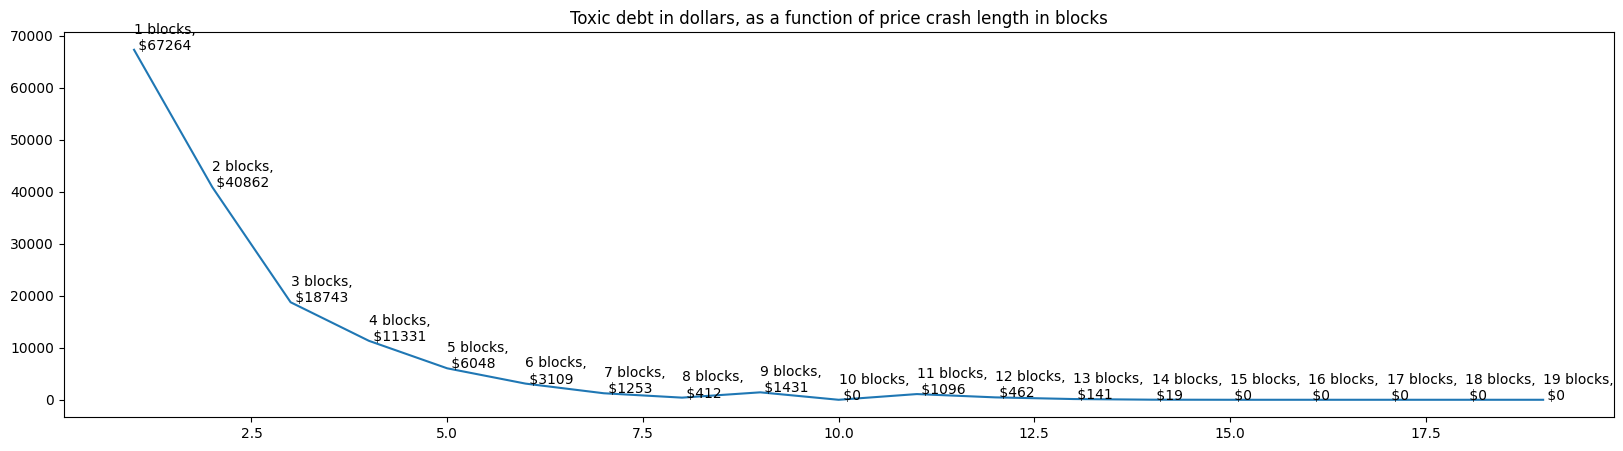

In [9]:
plt.figure(figsize=(20, 5))
plt.plot(run_lengths, toxic_debt)
for i in range(len(run_lengths)):
    plt.annotate(f"{run_lengths[i]} blocks,\n ${round(toxic_debt[i])}", (run_lengths[i], toxic_debt[i]))
plt.title("Toxic debt in dollars, as a function of price crash length in blocks")
plt.show()

In [10]:
hdx_sell_total * omnipool.usd_price('HDX', 'USDT')

969131.338891462

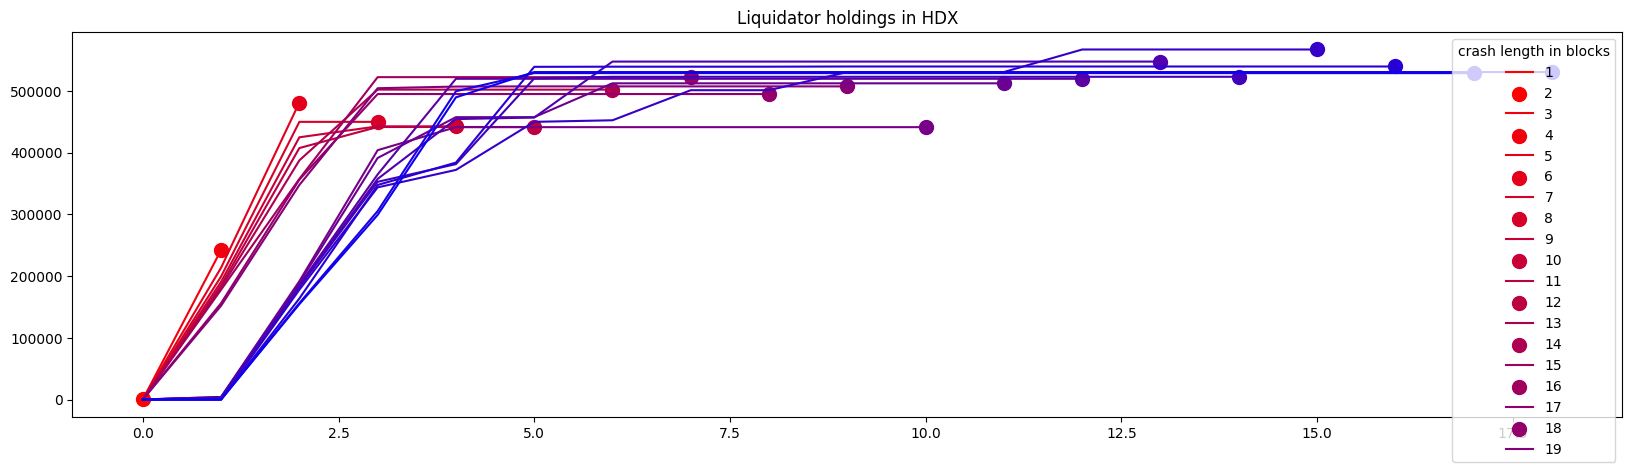

In [11]:
from model import plot_utils as pu
plt.figure(figsize=(20, 5))
colors = pu.color_gradient(len(run_lengths), (255, 0, 0), (0, 0, 255))
for i in range(len(run_lengths)):
    events = runs[i]
    color = colors[i]
    plt.plot([event.agents['liquidator'].holdings['HDX'] for event in events], color)
    plt.scatter(len(events) - 1, events[-1].agents['liquidator'].holdings['HDX'], color=color, s=100)
plt.legend(run_lengths, title='crash length in blocks')
plt.title('Liquidator holdings in HDX')
plt.show()

In [12]:
1 - runs[9][-1].pools['omnipool'].usd_price('HDX', 'USDT') / (omnipool.usd_price('HDX', 'USDT') / 4)

0.11817868919570762

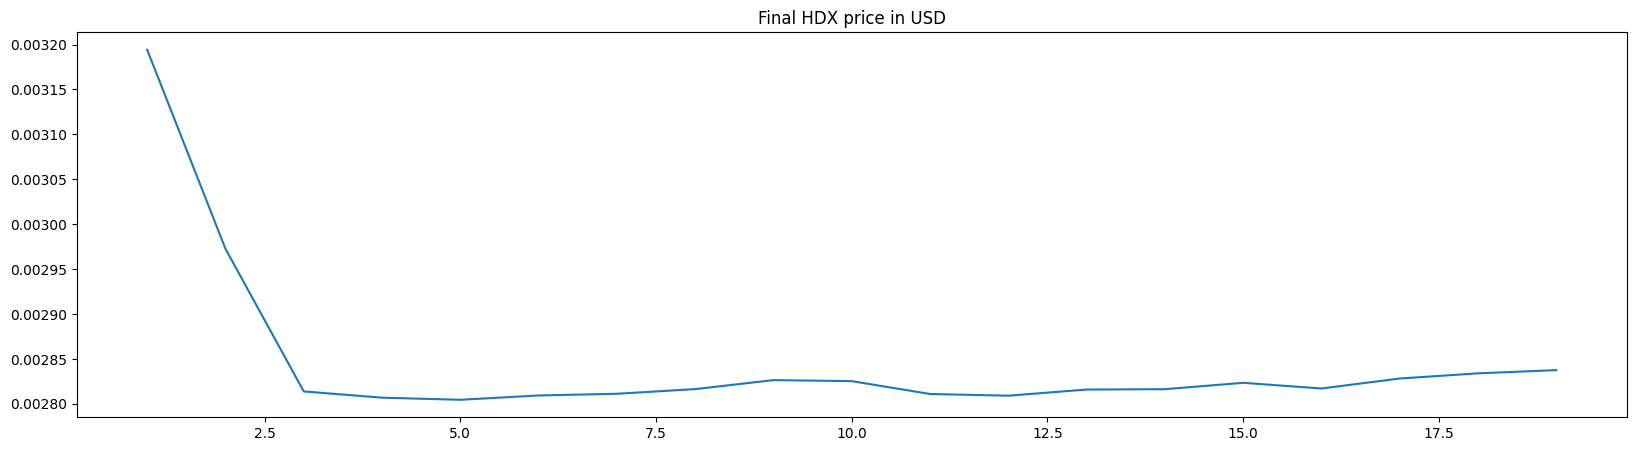

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(run_lengths, [events[-1].pools['omnipool'].usd_price('HDX', 'USDT') for events in runs])
plt.title('Final HDX price in USD')
plt.show()

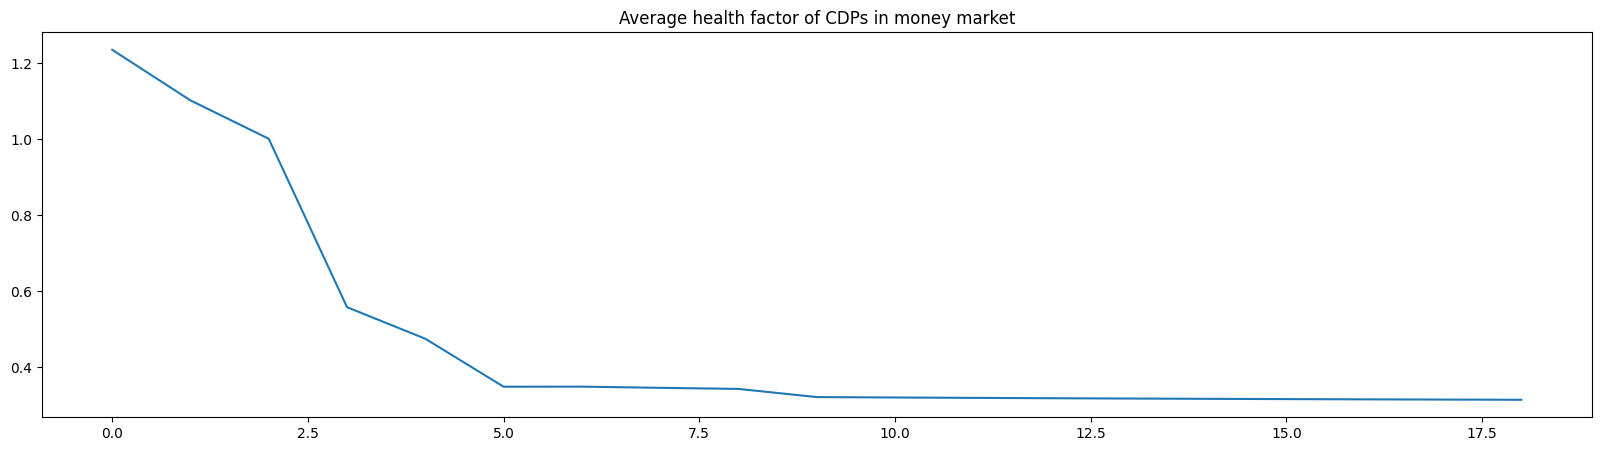

In [14]:
plt.figure(figsize=(20, 5))
plt.plot([sum([event.money_market.get_health_factor(cdp) for cdp in event.money_market.cdps]) / len(event.money_market.cdps) for event in events])
plt.title('Average health factor of CDPs in money market')
plt.show()

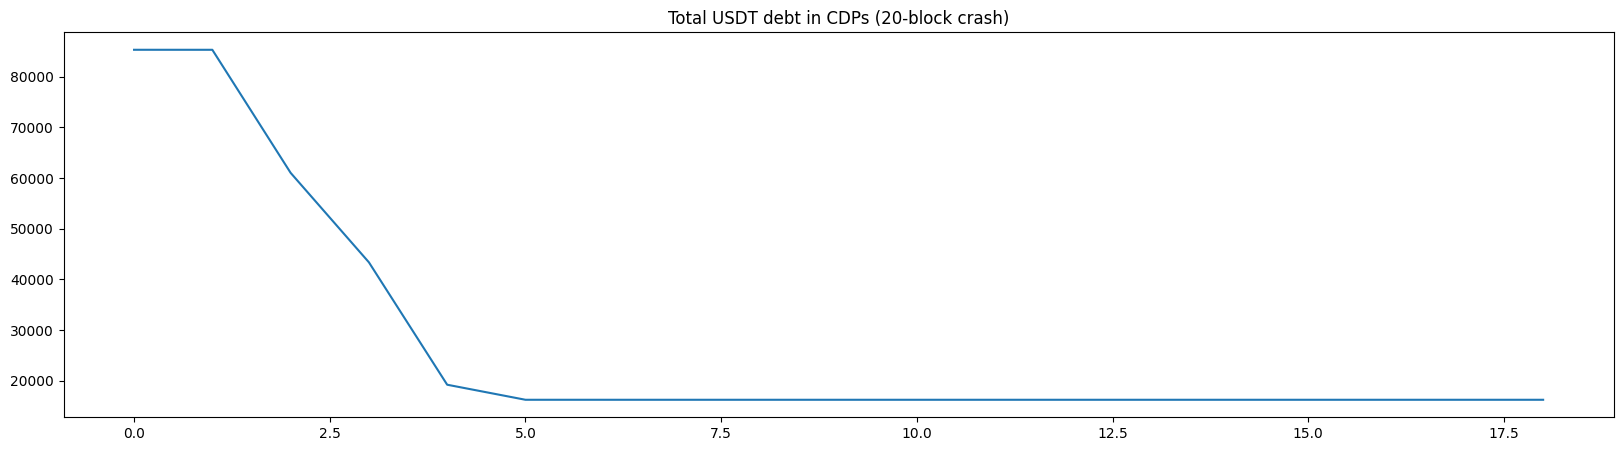

In [15]:
plt.figure(figsize=(20, 5))
liquidated_cdps = [sum([sum(cdp.debt.values()) for cdp in event.money_market.cdps]) for event in runs[-1]]
plt.plot(liquidated_cdps)
plt.title('Total USDT debt in CDPs (20-block crash)')
plt.show()

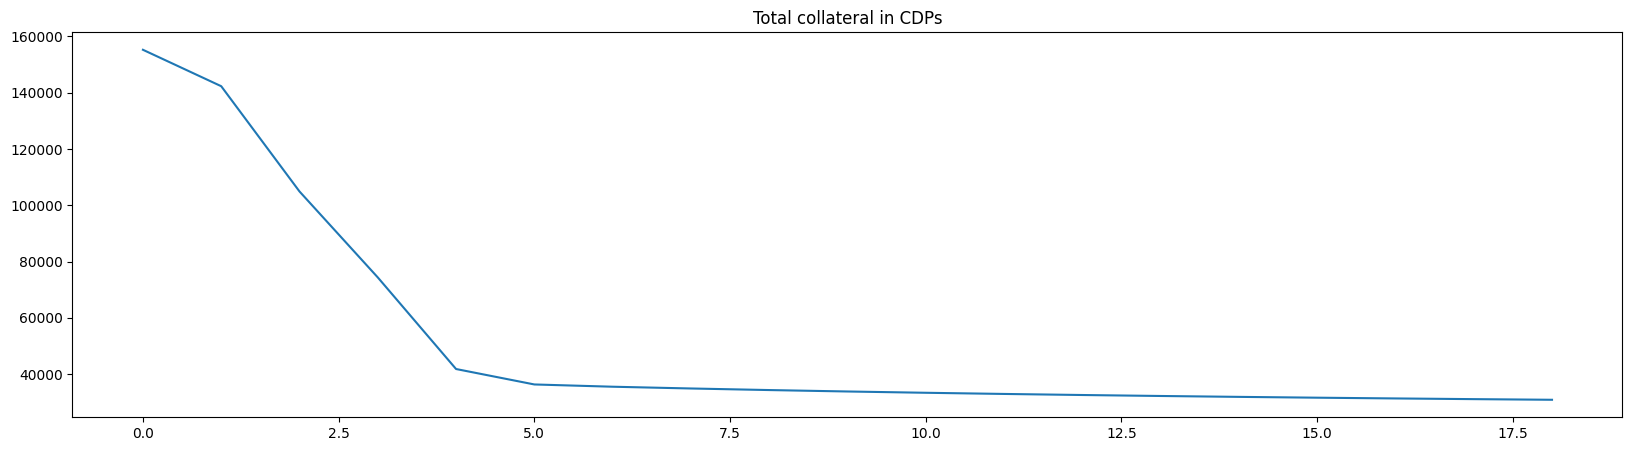

In [16]:
plt.figure(figsize=(20, 5))
liquidated_cdps = [sum([sum([cdp.collateral[c] * event.external_market[c] for c in cdp.collateral]) for cdp in event.money_market.cdps]) for event in events]
plt.plot(liquidated_cdps)
plt.title('Total collateral in CDPs')
plt.show()

In [17]:
print([events[-1].pools['omnipool'].lrna_price('HDX') for events in runs])
print([events[0].pools['omnipool'].lrna_price('HDX') for events in runs])
print(hdx_sell_total)
print(omnipool.liquidity['HDX'])
print(runs[0][-1].pools['omnipool'].lrna_price('HDX') / runs[0][0].pools['omnipool'].lrna_price('HDX'))

[0.00014901952131688697, 0.00013951048910901468, 0.0001326816691421309, 0.00013262982920980962, 0.0001326235294461379, 0.00013293517977722096, 0.0001331269887001121, 0.00013333843655409297, 0.00013378412663818542, 0.00013377591742496023, 0.00013306513142788762, 0.00013299692552112672, 0.00013332834676823833, 0.00013335114030896917, 0.00013369016774731352, 0.00013339207509999979, 0.00013391657784253514, 0.00013418568061573946, 0.00013435809637202373]
[0.00014901952131688697, 0.0002649235800249565, 0.0003352938974721309, 0.00038148993976770364, 0.00041394307280886, 0.00043793487222527395, 0.00045637223198911875, 0.00047097522155005976, 0.0004828231903357633, 0.000492626455464717, 0.00050087110540574, 0.0005079007883733749, 0.0005139652208224841, 0.0005192501747409465, 0.0005238966849281002, 0.0005280137347952594, 0.000531686862220392, 0.0005349841367100088, 0.0005379603983363477]
75619050.60963228
75619050.60963228
1.0


In [18]:
toxic_debt = []

for i, event in enumerate(runs[-1]):
    toxic_debt.append([])
    for j, cdp in enumerate(event.money_market.cdps):
        if event.pools['omnipool'].value_assets(cdp.debt, numeraire='USDT') > event.pools['omnipool'].value_assets(cdp.collateral, numeraire='USDT'):
            # bad debt
            toxic_debt[i].append({
                'debt': {
                    'assets': cdp.debt,
                    'value': event.pools['omnipool'].value_assets(cdp.debt, numeraire='USDT')
                },
                'collateral': {
                    'assets': cdp.collateral,
                    'value': event.pools['omnipool'].value_assets(cdp.collateral, numeraire='USDT')
                },
                'index': j
            })

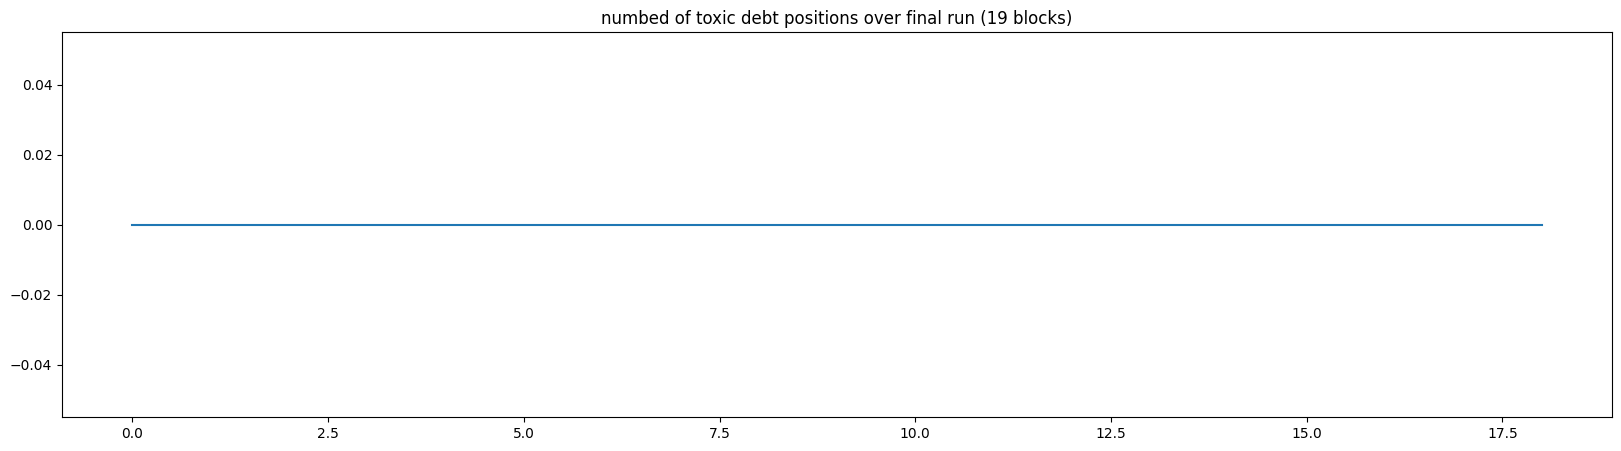

In [19]:
plt.figure(figsize=(20, 5))
plt.plot([len(step) for step in toxic_debt])
plt.title(f"numbed of toxic debt positions over final run ({len(toxic_debt)} blocks)")
plt.show()

In [20]:
for cdp in toxic_debt[-1]:
    print(f"  index: {cdp['index']}")
    print(f"    debt: {cdp['debt']}")
    print(f"    collateral: {cdp['collateral']}")

In [21]:
for i in [cdp['index'] for cdp in toxic_debt[-1]]:
    print(hdx_cdps[i])
    print('    value:')
    for tkn in hdx_cdps[i].collateral:
        print(f"{tkn}: {mm.value_assets({tkn: hdx_cdps[i].collateral[tkn]})}")

In [22]:
omnipool_router.exchanges

ZeroDivisionError: division by zero